# Using tabnet modules with skorch

This is an example of how to use a tabnet classifier with skorch,
as you might want to benefit from a tighter GridSearch integration,
distributed grid-search, visual print logs or integration with
experiment management services.

As pytorch-tabnet is already very similar to skorch in its layout we can re-use much of the existing code
to write our own skorch-tabnet wrapper.

To keep things simple and comparable this notebook will be based on the example 
from:

https://github.com/dreamquark-ai/tabnet/blob/develop/census_example.ipynb

## data loading

This section is taken 1:1 from the aforementioned example notebook with the one 
exception that we run the `y` values through a `LabelEncoder` before passing it 
further down to the model.

In [1]:
from sklearn.preprocessing import LabelEncoder

import torch
import pandas as pd
import numpy as np
np.random.seed(0)

import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [3]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

File already exists.


In [4]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [5]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3


In [6]:
# check that pipeline accepts strings
train.loc[train[target]==0, target] = "wealthy"
train.loc[train[target]==1, target] = "not_wealthy"

In [7]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [8]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [9]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

LabelEncoder()

In [10]:
y_train_enc = label_encoder.transform(y_train)
y_valid_enc = label_encoder.transform(y_valid)

## skorch tabnet port

Under the hood tabnet is very similar to skorch as it, too, provides a sklearn wrapper.
There are features, like `set_params` that are not as well supported which could make
grid searches more complicated which is why you might be interested in a way to use
skorch with the low-level tabnet modules instead of the highlevel interface.

Here's a recipe for a classifier as an example for this.

In [11]:
import skorch
from skorch.helper import predefined_split

from sklearn.metrics import roc_auc_score

import pytorch_tabnet
from pytorch_tabnet.multiclass_utils import infer_output_dim
from pytorch_tabnet.tab_network import TabNet
from pytorch_tabnet.utils import create_explain_matrix

from torch.nn import CrossEntropyLoss

from scipy.sparse import csc_matrix

Since tabnet provides high-level code for computing feature importances during training
we need to have an equivalent for that. To implement this we create our own neural network
instance which implements a hook that's called on end of training to compute feature importances and provides methods to do feature explanation.

We base our `SkorchTabModel` on skorch's `NeuralNetClassifier` as we deal with an classification task (obviously) and this base class gives us features such as automatic
inference of used classes (i.e. the `model.classes_` attribute) which sklearn depends
on at times.

In [12]:
class SkorchTabModel(skorch.NeuralNetClassifier):
    def __init__(
        self,
        criterion,
        module=TabNet, 
        module__input_dim=100, 
        module__output_dim=5,
        **kwargs,
    ):
        super().__init__(
            module,
            criterion=criterion,
            module__input_dim=module__input_dim,
            module__output_dim=module__output_dim,
            **kwargs,
        )
        
    def initialize_module(self):
        """Setup the network and explain matrix."""
        kwargs =  self.get_params_for('module')

        self.module_ = TabNet(**kwargs).to(self.device)

        self.reducing_matrix_ = create_explain_matrix(
            self.module_.input_dim,
            self.module_.cat_emb_dim,
            self.module_.cat_idxs,
            self.module_.post_embed_dim,
        )
        
    def compute_feature_importances(self, X):
        """Compute global feature importance; based on tabnet code."""      
        feature_importances_ = np.zeros((self.module_.post_embed_dim))
        
        for (M_explain, masks) in self.forward_masks_iter(X):
            feature_importances_ += M_explain.sum(dim=0).cpu().detach().numpy()

        feature_importances_ = csc_matrix.dot(
            feature_importances_, self.reducing_matrix_,
        )
        return feature_importances_ / np.sum(feature_importances_)
        
    def on_train_end(self, net, X, **kwargs):
        # We compute feature importances every time fit() ends
        self.feature_importances_ = self.compute_feature_importances(X)
        super().on_train_end(net, X=X, **kwargs)
        
    def forward_masks_iter(self, X, training=False, device='cpu'):
        # based on the forward_iter recipe in skorch.NeuralNet;
        # basically the same but calls forward_masks() instead of forward()
        dataset = self.get_dataset(X)
        iterator = self.get_iterator(dataset, training=training)
        for data in iterator:
            Xi = skorch.dataset.unpack_data(data)[0]
            Xi = skorch.utils.to_device(Xi, self.device)
            with torch.set_grad_enabled(False):
                yp = self.module_.forward_masks(Xi)
                yield skorch.utils.to_device(yp, device=device)
    
    def explain(self, X):
        """
        Return local explanation.
        Taken almost exactly from tabnet code.

        Parameters
        ----------
        X : tensor: `torch.Tensor`
            Input data

        Returns
        -------
        M_explain : matrix
            Importance per sample, per columns.
        masks : matrix
            Sparse matrix showing attention masks used by network.
        """
        res_explain = []
        
        for i, (M_explain, masks) in enumerate(self.forward_masks_iter(X)):
            for key, value in masks.items():
                masks[key] = csc_matrix.dot(
                    value.cpu().detach().numpy(), self.reducing_matrix_
                )

            res_explain.append(
                csc_matrix.dot(M_explain.cpu().detach().numpy(), self.reducing_matrix_)
            )

            if i == 0:
                res_masks = masks
            else:
                for key, value in masks.items():
                    res_masks[key] = np.vstack([res_masks[key], value])
            
        res_explain = np.vstack(res_explain)
        return res_explain, res_masks
    
    def predict(self, X):
        y_proba = self.predict_proba(X)
        return y_proba.argmax(-1)

tabnet enforces sparsity via the loss function (as an additional loss term) which
is returned by the module. Since skorch defaults to expecting a single term loss
we simply implement a criterion that can handle both terms returned by the module.
To do this, we just leverage the existing `CrossEntropyLoss`, execute its 
`forward`-step and add the sparsity term based on the masks returned by the module.

In [13]:
class CrossEntropySparsityLoss(torch.nn.CrossEntropyLoss):
    def __init__(self, lambda_sparse=1e-3):
        super().__init__()
        self.lambda_sparse = lambda_sparse
        
    def forward(self, y_pred, y_true):
        output, M_loss = y_pred

        loss = super().forward(output, y_true)
        
        # Add the overall sparsity loss
        loss -= self.lambda_sparse * M_loss
        
        return loss

In terms of parametrization we just copy the parameters over from the tabnet example notebook.
Parameters that actually belong to the PyTorch module are now set directly via skorch's
`module__<param>` notation.

We also use skorch's `LRScheduler`, `EarlyStopping`, `GradientNormClipping` and `*Scoring`
callbacks to re-implement the training regiment the original notebook uses.

Note that for `EarlyStopping` to work we need a validation loss during training which we
only have once we add validation data. The difference to the original notebook is that
we supply this data at initialization time instead of training time via the `train_split`
parameter.

Having a validation split during train-time makes it possible to use `EpochScoring` with the sklearn `roc_auc` score
so that we can monitor the target score during training as well.
Since skorch caches the network's outputs by default, no recomputation
is necessary and score computation is fast.

Lastly, to take advantage of the early stopping, we checkpoint the model every time
the the `roc_auc` score registered its best value yet. From this we can recover the
best model after training, even when early stopping triggered 20 epochs later.

In [14]:
torch.manual_seed(0)

skorch_clf = SkorchTabModel(
    criterion=CrossEntropySparsityLoss,
    
    # Configure the module the same as in the tabnet example.
    module__input_dim=X_train.shape[-1],
    module__output_dim=infer_output_dim(y_train)[0],
    module__cat_idxs=cat_idxs,
    module__cat_dims=cat_dims,
    module__cat_emb_dim=1,
    module__mask_type='entmax',
    module__virtual_batch_size=128,
    
    optimizer=torch.optim.Adam,
    optimizer__lr=2e-2,
    
    batch_size=1024,
    iterator_train__num_workers=0,
    iterator_train__drop_last=False,
    iterator_valid__num_workers=0,
    iterator_valid__drop_last=False,
    
    callbacks=[
        skorch.callbacks.LRScheduler(
            policy=torch.optim.lr_scheduler.StepLR,
            step_size=50,
            gamma=0.9,
        ),
        skorch.callbacks.EarlyStopping(patience=20),
        skorch.callbacks.GradientNormClipping(gradient_clip_value=1.),
        skorch.callbacks.EpochScoring(
            'roc_auc', name='val_roc_auc', lower_is_better=False,
        ),
        skorch.callbacks.Checkpoint(monitor='val_roc_auc_best'),
    ],
    
    train_split=skorch.helper.predefined_split(
        skorch.dataset.Dataset(X_valid, y_valid_enc)),
    
    # The actual number of epochs will be much lower due to EarlyStopping
    max_epochs=1000,
    
    device='cuda',
)

In [15]:
skorch_clf.fit(
    X_train, 
    y_train_enc,
);

  epoch    train_loss    val_roc_auc    valid_acc    valid_loss    cp      lr     dur
-------  ------------  -------------  -----------  ------------  ----  ------  ------
      1        0.4923         0.7858       0.7678        0.4510     +  0.0200  1.7736
      2        0.4203         0.8283       0.7895        0.4172     +  0.0200  1.5999
      3        0.3933         0.8489       0.8100        0.4054     +  0.0200  1.6388
      4        0.3667         0.8799       0.8292        0.3636     +  0.0200  1.6323
      5        0.3486         0.8879       0.8311        0.3566     +  0.0200  1.6902
      6        0.3361         0.8971       0.8395        0.3452     +  0.0200  1.6289
      7        0.3264         0.8968       0.8308        0.3479        0.0200  1.6241
      8        0.3173         0.9023       0.8404        0.3471     +  0.0200  1.6586
      9        0.3080         0.9015       0.8249        0.3678        0.0200  1.6811
     10        0.3016         0.9028       0.8134     

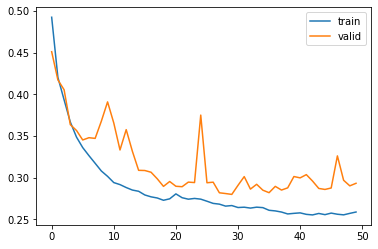

In [16]:
plt.plot(skorch_clf.history[:, ('train_loss', 'valid_loss')])
plt.legend(['train', 'valid']);

### Score on the validation set

In [17]:
# load the best parameters stored by the checkpoint callback
skorch_clf.load_params(checkpoint=dict(skorch_clf.callbacks_)['Checkpoint'])

In [18]:
roc_auc_score(y_valid_enc, skorch_clf.predict_proba(X_valid)[:, 1])

0.9286215045377348

### Grid search

Can we do better? Let's try to find better hyper-parameters using a grid search on a 3-fold split of the training data using sklearn's `GridSearchCV`.

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
params = {
    'module__n_steps': [3, 4, 5],
    'optimizer__lr': [2e-2, 2e-3],
    'verbose': [False],
}

In a better world we would use a split from the training data both for the 
base model configuration and for the grid search (e.g., using `StratifiedKFold`).
But to be better able to compare the results, we proceed by using a fixed 
train/validation split.

For the grid search this means that we have to use the whole dataset in the
`fit()` call and supply the train/validation indices via the `cv=` parameter.

In [21]:
X_gs = train[features].values
y_gs = train[target].values
y_gs_enc = label_encoder.transform(y_gs)

cv_idcs = [(train_indices.to_numpy(), valid_indices.to_numpy())]

In [22]:
gs = GridSearchCV(skorch_clf, params, cv=cv_idcs, scoring='roc_auc', verbose=1)

In [23]:
%%time
gs.fit(X_gs, y_gs_enc)

Automatic pdb calling has been turned ON
Fitting 1 folds for each of 6 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 17.4min finished


CPU times: user 23min 25s, sys: 17.5 s, total: 23min 43s
Wall time: 23min 52s


GridSearchCV(cv=[(array([    0,     1,     2, ..., 32557, 32558, 32559]),
                  array([    7,    17,    19, ..., 32542, 32548, 32556]))],
             estimator=<class '__main__.SkorchTabModel'>[initialized](
  module_=TabNet(
    (embedder): EmbeddingGenerator(
      (embeddings): ModuleList(
        (0): Embedding(73, 1)
        (1): Embedding(9, 1)
        (2): Embedding(16, 1)
        (3): Embedding(16, 1)
        (4): Embedding(7, 1)
        (5): Embedding(15, 1)
        (6): Embedding(6, 1...
            (fc): Linear(in_features=8, out_features=14, bias=False)
            (bn): GBN(
              (bn): BatchNorm1d(14, eps=1e-05, momentum=0.02, affine=True, track_running_stats=True)
            )
            (selector): Entmax15()
          )
        )
      )
      (final_mapping): Linear(in_features=8, out_features=2, bias=False)
    )
  ),
),
             param_grid={'module__n_steps': [3, 4, 5],
                         'optimizer__lr': [0.02, 0.002], 'verbose': [F

In [24]:
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_module__n_steps,param_optimizer__lr,param_verbose,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,123.638970,0.0,0.109033,0.0,3,0.02,False,"{'module__n_steps': 3, 'optimizer__lr': 0.02, ...",0.921506,0.921506,0.0,2
1,123.379832,0.0,0.095594,0.0,3,0.002,False,"{'module__n_steps': 3, 'optimizer__lr': 0.002,...",0.873245,0.873245,0.0,6
2,144.896835,0.0,0.102971,0.0,4,0.02,False,"{'module__n_steps': 4, 'optimizer__lr': 0.02, ...",0.917003,0.917003,0.0,3
3,142.136357,0.0,0.100738,0.0,4,0.002,False,"{'module__n_steps': 4, 'optimizer__lr': 0.002,...",0.878836,0.878836,0.0,5
4,247.821962,0.0,0.119188,0.0,5,0.02,False,"{'module__n_steps': 5, 'optimizer__lr': 0.02, ...",0.927573,0.927573,0.0,1
5,261.196265,0.0,0.117020,0.0,5,0.002,False,"{'module__n_steps': 5, 'optimizer__lr': 0.002,...",0.880725,0.880725,0.0,4


In [25]:
gs.best_params_

{'module__n_steps': 5, 'optimizer__lr': 0.02, 'verbose': False}

### Comparison: did we get better?

In [26]:
roc_auc_score(y_valid_enc, skorch_clf.predict_proba(X_valid)[:, 1])

0.9286215045377348

In [27]:
skorch_gs_clf = gs.best_estimator_

In [28]:
roc_auc_score(y_valid_enc, skorch_gs_clf.predict_proba(X_valid)[:, 1])

0.9350759769607937

It seems that we did, even though only marginally. One reason might be that the model was already well tuned and that there is not much room for improvement, another could be that the CV-split we used in the grid-search was not approximating the final model performance well or early stopping was too eager. Finally, only a small parameter space was examined. For brevity we will not explore this further, though.

### Feature importances

We can take a look at the (accumulated) global feature importances and look at what the
difference between the base model and the best performing model from the grid search
looks like. This way we could reason about the performance difference. We are not going
to do that here, though.

In [29]:
df = pd.DataFrame(index=features, data={
    'base': skorch_clf.feature_importances_,
    'best': skorch_gs_clf.feature_importances_,
})

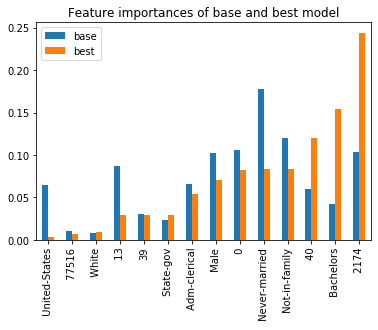

In [30]:
df.sort_values(by='best').plot(
    kind='bar', title='Feature importances of base and best model');

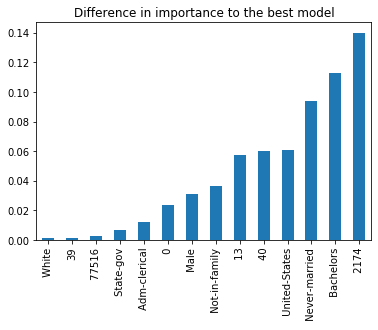

In [31]:
# show the absolute difference between feature importances of the old and the new
# grid searched model
df.diff(axis=1).abs().sort_values(by='best').best.plot(
    kind='bar', title='Difference in importance to the best model');

### Per-sample feature importances

tabnet also allows us to plot the per-sample attention weights and lets us deduce which features were the most important in each of the steps the network takes to form a decision. We can visualize these per-sample masks and compare them, visually, to the grid-searched model and see that they, indeed, focus on different aspects.

#### Per-sample weights of the skorch base model

In [32]:
explain_matrix, masks = skorch_clf.explain(X_valid)

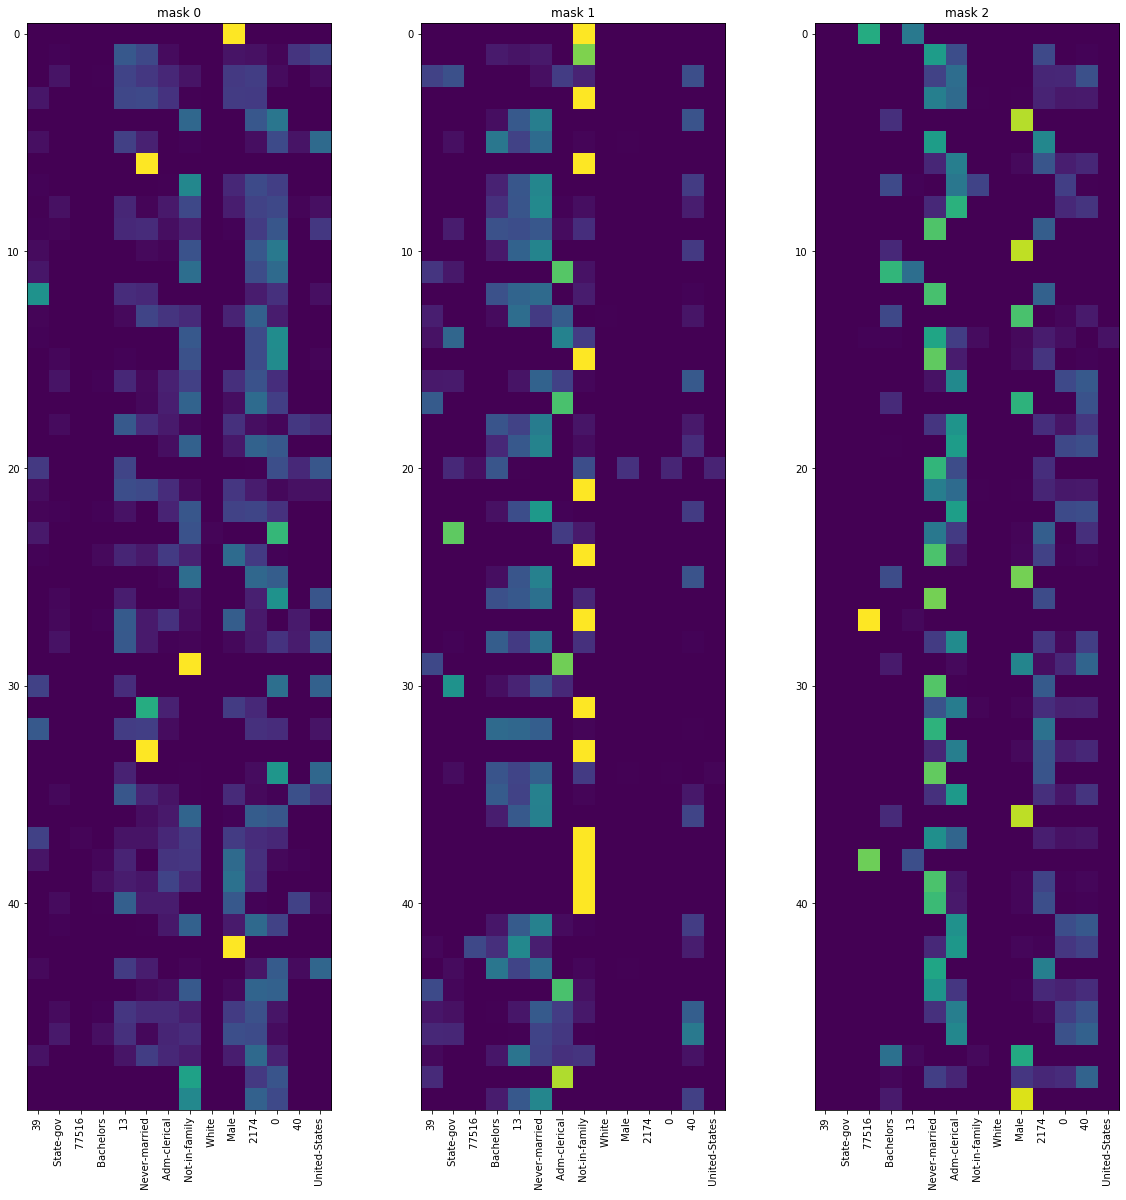

In [33]:
n_steps = skorch_clf.module_.n_steps
fig, axs = plt.subplots(1, n_steps, figsize=(20,20))

for i in range(n_steps):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")
    axs[i].set_xticks(list(range(len(features))))
    axs[i].set_xticklabels(features, rotation=90)

#### Per-sample weights of the grid-searched model

In [34]:
explain_matrix, masks = skorch_gs_clf.explain(X_valid)

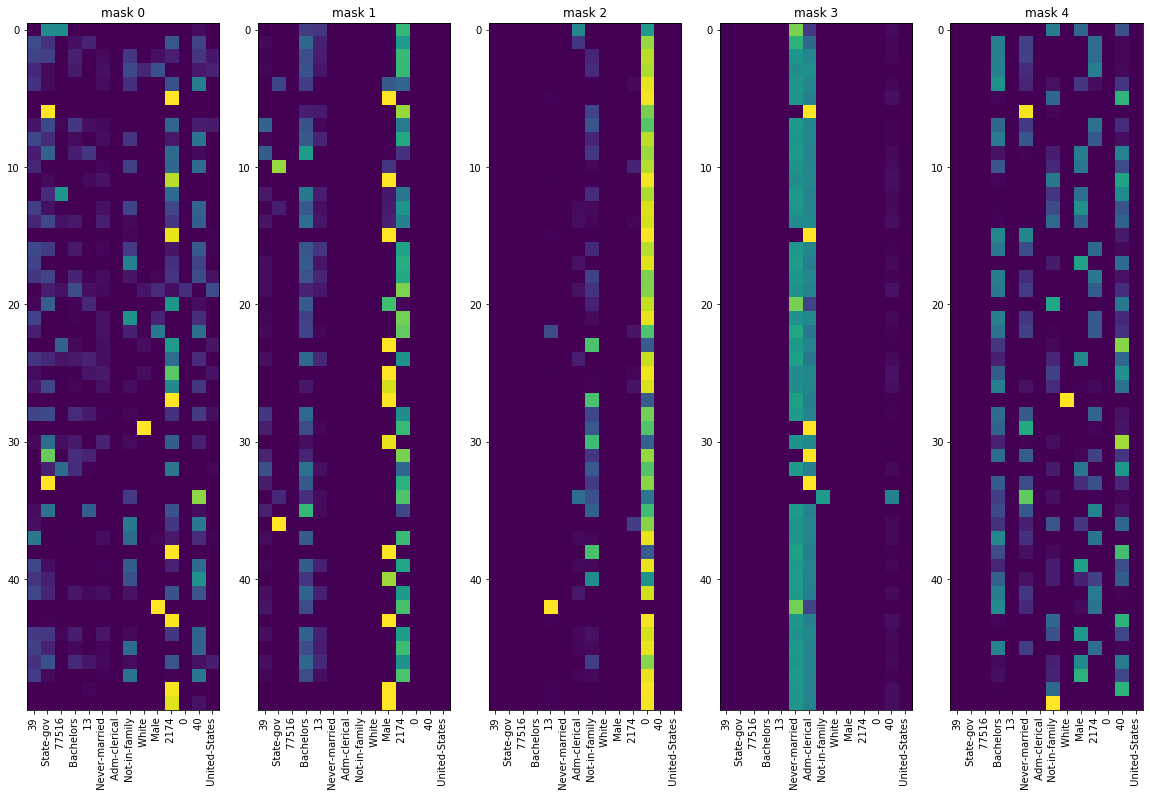

In [35]:
n_steps = skorch_gs_clf.module_.n_steps
fig, axs = plt.subplots(1, n_steps, figsize=(20,20))

for i in range(n_steps):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")
    axs[i].set_xticks(list(range(len(features))))
    axs[i].set_xticklabels(features, rotation=90)